<a href="https://colab.research.google.com/github/Ekalabya3/Abhilash-2D2V/blob/main/Abhilash_2D_PIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
from scipy.fft import fftfreq, fft2, ifft2
import matplotlib.pyplot as plt

In [57]:
def periodic_particles(x, y, length):

    x %= length
    y %= length

    return x, y

In [58]:
def charge_density(pos_x, pos_y, dx, dy, length):    #DONE

    charge_density = np.zeros((int(length / dx) +1 , int(length / dy) + 1))

    # LOOPING
    for p in range(nparticles):
        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)

        # GRID POINT FINDER
        i = int(pos_x[p] / dx)
        j = int(pos_y[p] / dy)

        # IF INDEX BECAME NEGATIVE
        if i < 0:
            i += abs(ncell ** 0.5) + 1
        if j < 0:
            j += abs(ncell ** 0.5) + 1

        # FRACTION FINDER
        x_frac = (pos_x[p] - (i * dx)) / dx
        y_frac = (pos_y[p] - (j * dy)) / dy
        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        charge_density[i][j]     =   charge_density[i][j]     + (particle_charge * weight_ii) #/ (dx*dy)
        charge_density[(i+1)][j]   =   charge_density[(i+1)][j]   + (particle_charge * weight_ji) #/ (dx*dy)
        charge_density[i][(j+1)]   =   charge_density[i][(j+1)]   + (particle_charge * weight_ij) #/ (dx*dy)
        charge_density[(i+1)][(j+1)] =   charge_density[(i+1)][(j+1)] + (particle_charge * weight_jj) #/ (dx*dy)

        transpose_charge_density = np.transpose(charge_density)
        rho_1 = (np.flip(transpose_charge_density, 0)) / (dx*dy)

    return  rho_1

In [59]:
def calculate_background_charge_density(dx, dy, length, particle_charge, nparticles):  #DONE

    # FIRST: TOTAL CHARGE CALCULATION
    total_particle_charge = particle_charge * nparticles

    # SECOND: TOTAL NUMBER OF GRID POINTS
    num_x_cells = int(length / dx) + 1
    num_y_cells = int(length / dy) + 1
    total_grid_points = num_x_cells * num_y_cells

    # THIRD: CHARGE DENSITY BY BACKGROUND PARTICLES (IONS)
    background_charge_density = (np.ones((num_x_cells, num_y_cells)) * (-total_particle_charge / total_grid_points)) / (dx * dy)   #/ (length*length)

    return background_charge_density

In [60]:
def poisson_solver(rho, dx, dy):
    # Calculate Wavenumbers
    k_x = fftfreq(rho.shape[1], dx)
    k_y = fftfreq(rho.shape[0], dy)

    # Compute Fourier transform of charge density
    rho_hat = fft2(rho)

    # Compute potential in Fourier space
    kx_grid, ky_grid = np.meshgrid(k_x, k_y, indexing='ij')
    kx_grid_sq = kx_grid ** 2
    ky_grid_sq = ky_grid ** 2
    k_sq = kx_grid_sq + ky_grid_sq

    # Avoid division by zero at zero frequency
    k_sq[0, 0] = 1.0
    potential_hat = rho_hat / (4 * np.pi ** 2 * k_sq)

    # Compute electric field components in Fourier space
    E_x_hat = -1j * 2 * np.pi * kx_grid * potential_hat
    E_y_hat = -1j * 2 * np.pi * ky_grid * potential_hat

    # Compute inverse Fourier transform to get electric field in real space
    E_x = np.real(ifft2(E_x_hat))
    E_y = np.real(ifft2(E_y_hat))
    electric_potential = np.real(ifft2(potential_hat))

    return E_x, E_y, k_sq, electric_potential

In [61]:
def interpolate_field (pos_x, pos_y, dx, dy, length, E_x, E_y):

    Ex_at_particle = np.zeros(len(pos_x))
    Ey_at_particle = np.zeros(len(pos_y))

    # LOOPING
    for p in range(nparticles):
        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)

        # GRID POINT FINDER
        i = (int(pos_x[p] / dx))
        j = (int(pos_y[p] / dy))

        # IF INDEX BECAME NEGATIVE
        if i < 0:
            i += abs(ncell ** 0.5) + 1
        if j < 0:
            j += abs(ncell ** 0.5) + 1

        # FRACTION FINDER
        x_frac = (pos_x[p] - (i * dx)) / dx
        y_frac = (pos_y[p] - (j * dy)) / dy

        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        Ex_at_particle[p] = weight_ii * E_x[i][j] + weight_ji * E_x[(i+1)][j] + weight_ij * E_x[i][(j+1)] + weight_jj * E_x[(i+1)][(j+1)]
        Ey_at_particle[p] = weight_ii * E_y[i][j] + weight_ji * E_y[(i + 1)][j] + weight_ij * E_y[i][(j + 1)] + weight_jj * E_y[(i + 1)][(j + 1)]
        force_x = particle_charge * Ex_at_particle[p]
        force_y = particle_charge * Ey_at_particle[p]
        acc_x = force_x
        acc_y = force_y

    return Ex_at_particle, Ey_at_particle, force_x, force_y, acc_x, acc_y

In [62]:
nparticles = 100000
ncell = 2500
length = 10  # DONT CHANGE
n_step = 100
t = 0
dt = 0.01
particle_charge = 1
iteration = 0

In [63]:
position_x = np.random.uniform(0, length, nparticles)
position_y = np.random.uniform(0, length, nparticles)
vel_x = np.random.uniform(-0.1, 0.1, nparticles)
vel_y = np.random.uniform(-0.01, 0.01, nparticles)

In [64]:
dx = length / abs(ncell ** 0.5)
dy = length / abs(ncell ** 0.5)

In [65]:
#pos_x_list = []
#vel_x_list = []
#rho_total_list = []

In [66]:
' TESTS '
'''
position_x, position_y = periodic_particles(position_x, position_y, length)
rho_electron = charge_density(position_x, position_y, dx, dy, length)
background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
rho_total = background_charge_density + rho_electron
#print(force_x)
'''

'\nposition_x, position_y = periodic_particles(position_x, position_y, length)\nrho_electron = charge_density(position_x, position_y, dx, dy, length)\nbackground_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)\nrho_total = background_charge_density + rho_electron\n#print(force_x)\n'

In [67]:
for step in range(n_step):
    #pos_x_list = position_x
    #print(" POSITION X COORDINATES FOR EACH ITERATIONS \n", pos_x_list)

    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
    rho_total = background_charge_density + rho_electron

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vx_half = vel_x + (0.5 * dt * acceleration_x)
    vy_half = vel_y + (0.5 * dt * acceleration_y)

    position_x += vx_half * dt
    position_y += vy_half * dt

    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
    rho_total = background_charge_density + rho_electron

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vel_x = vx_half + 0.5 * dt * acceleration_x
    vel_y = vy_half + 0.5 * dt * acceleration_y


    print("TOTAL CHARGE DENSITY OF SYSTEM : ", np.sum(rho_total))
    print("TOTAL POTENTIAL OF SYSTEM : ", np.sum(electric_potential_grid))
    #vel_x_list.append(vel_x)
    #rho_total_list.append(rho_total)
    iteration += 1
    print("ITERATION : ", iteration)
    t += dt

TOTAL CHARGE DENSITY OF SYSTEM :  1.1641532182693481e-10
TOTAL POTENTIAL OF SYSTEM :  2.9103830456733704e-11
ITERATION :  1
TOTAL CHARGE DENSITY OF SYSTEM :  7.457856554538012e-11
TOTAL POTENTIAL OF SYSTEM :  3.637978807091713e-11
ITERATION :  2
TOTAL CHARGE DENSITY OF SYSTEM :  9.094947017729282e-11
TOTAL POTENTIAL OF SYSTEM :  4.3655745685100555e-11
ITERATION :  3
TOTAL CHARGE DENSITY OF SYSTEM :  9.276845958083868e-11
TOTAL POTENTIAL OF SYSTEM :  3.637978807091713e-11
ITERATION :  4
TOTAL CHARGE DENSITY OF SYSTEM :  7.639755494892597e-11
TOTAL POTENTIAL OF SYSTEM :  4.3655745685100555e-11
ITERATION :  5
TOTAL CHARGE DENSITY OF SYSTEM :  7.275957614183426e-11
TOTAL POTENTIAL OF SYSTEM :  3.637978807091713e-11
ITERATION :  6
TOTAL CHARGE DENSITY OF SYSTEM :  8.549250196665525e-11
TOTAL POTENTIAL OF SYSTEM :  2.9103830456733704e-11
ITERATION :  7
TOTAL CHARGE DENSITY OF SYSTEM :  1.000444171950221e-10
TOTAL POTENTIAL OF SYSTEM :  2.9103830456733704e-11
ITERATION :  8
TOTAL CHARGE DENSI

In [68]:
#print("END POSITION X COORDINATES : \n ",pos_x_list)

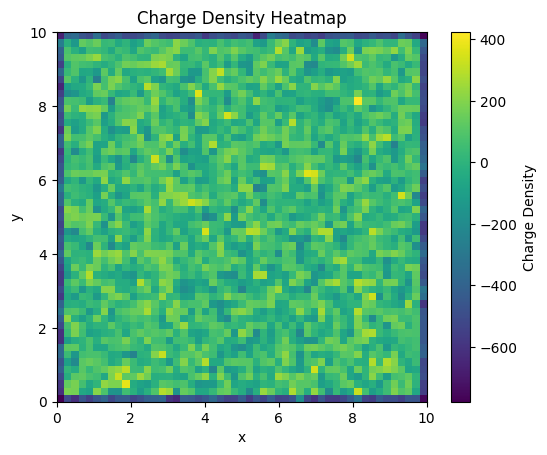

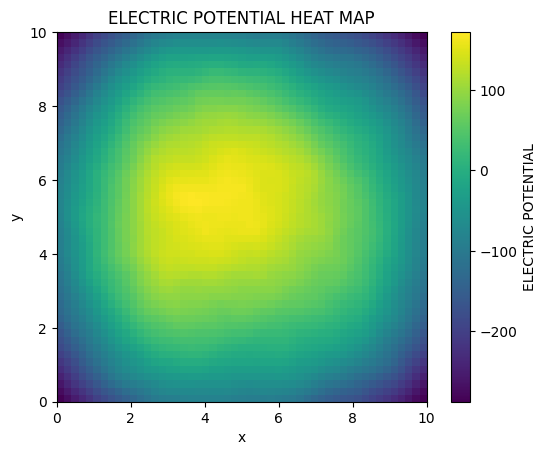

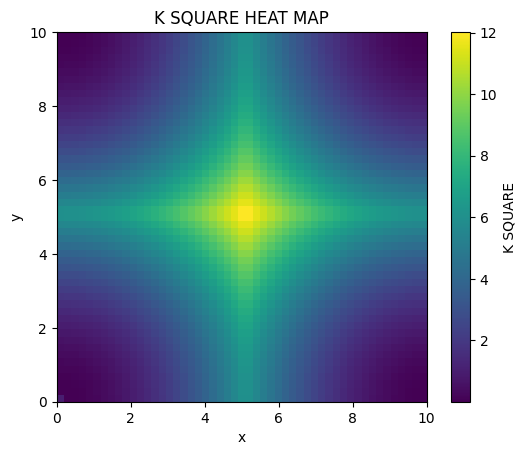

"\n\n\nplt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n\nplt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n\nplt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n"

In [69]:
plt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


plt.imshow(electric_potential_grid, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='ELECTRIC POTENTIAL')
plt.xlabel('x')
plt.ylabel('y')
plt.title('ELECTRIC POTENTIAL HEAT MAP')
plt.show()

plt.imshow(k_square, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='K SQUARE')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K SQUARE HEAT MAP')
plt.show()

'''


plt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()
'''